# 仕訳データの有効グラフ表現

簿記でいう勘定連絡図のようなものを有効グラフで表現してみます。勘定連絡図についてはググってください。

### 0. セットアップ

1. matplotlibに日本語のフォントを追加、設定します。

2. 今回は有限会社アイソフトの製品「税理士いらず」のサンプルデータ「株式会社サンプルデザイン」をお借りします。以下のサイトから仕訳データをダウンロードし、好きな場所に置きます（以下ではこのスクリプトファイルと同じディレクトリに"testdata.csv"の名称で置いてあることを想定してます）。

http://www.z-irazu.jp/sample.html

### 1. データの読み込み

In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
filename='../Developing/testdata.csv'
JE_raw=pd.read_csv(filename, \
                   header=None,index_col=False, engine="python", encoding="SHIFT-JIS",\
                   names=['date','debit_account_name','debit_amount','debit_tax','credit_account_name','credit_amount','credit_tax','description_1','description_2'])

### 2. 行列データの作成

In [3]:
Names=np.concatenate([JE_raw.loc[:,'debit_account_name'].values,JE_raw.loc[:,'credit_account_name'].values])
TBindex=np.unique(Names)
transaction_mat=pd.DataFrame(np.zeros((TBindex.shape[0],TBindex.shape[0])),dtype=int)
transaction_mat.index=TBindex
transaction_mat.columns=TBindex
for itr in range(JE_raw.shape[0]):
    rcd=JE_raw.iloc[itr,:]
    mask_d=rcd["debit_account_name"] == TBindex
    mask_c=rcd["credit_account_name"] == TBindex
    transaction_mat.iloc[mask_d,mask_c]=transaction_mat.iloc[mask_d,mask_c]+rcd['debit_amount']
    
transaction_mat_net=pd.DataFrame(np.zeros((TBindex.shape[0],TBindex.shape[0])),dtype=int)
transaction_mat_net.index=TBindex
transaction_mat_net.columns=TBindex
transaction_mat_net.loc[:,:]=(transaction_mat.values+transaction_mat.values.transpose())/2

### 3. 無向グラフ

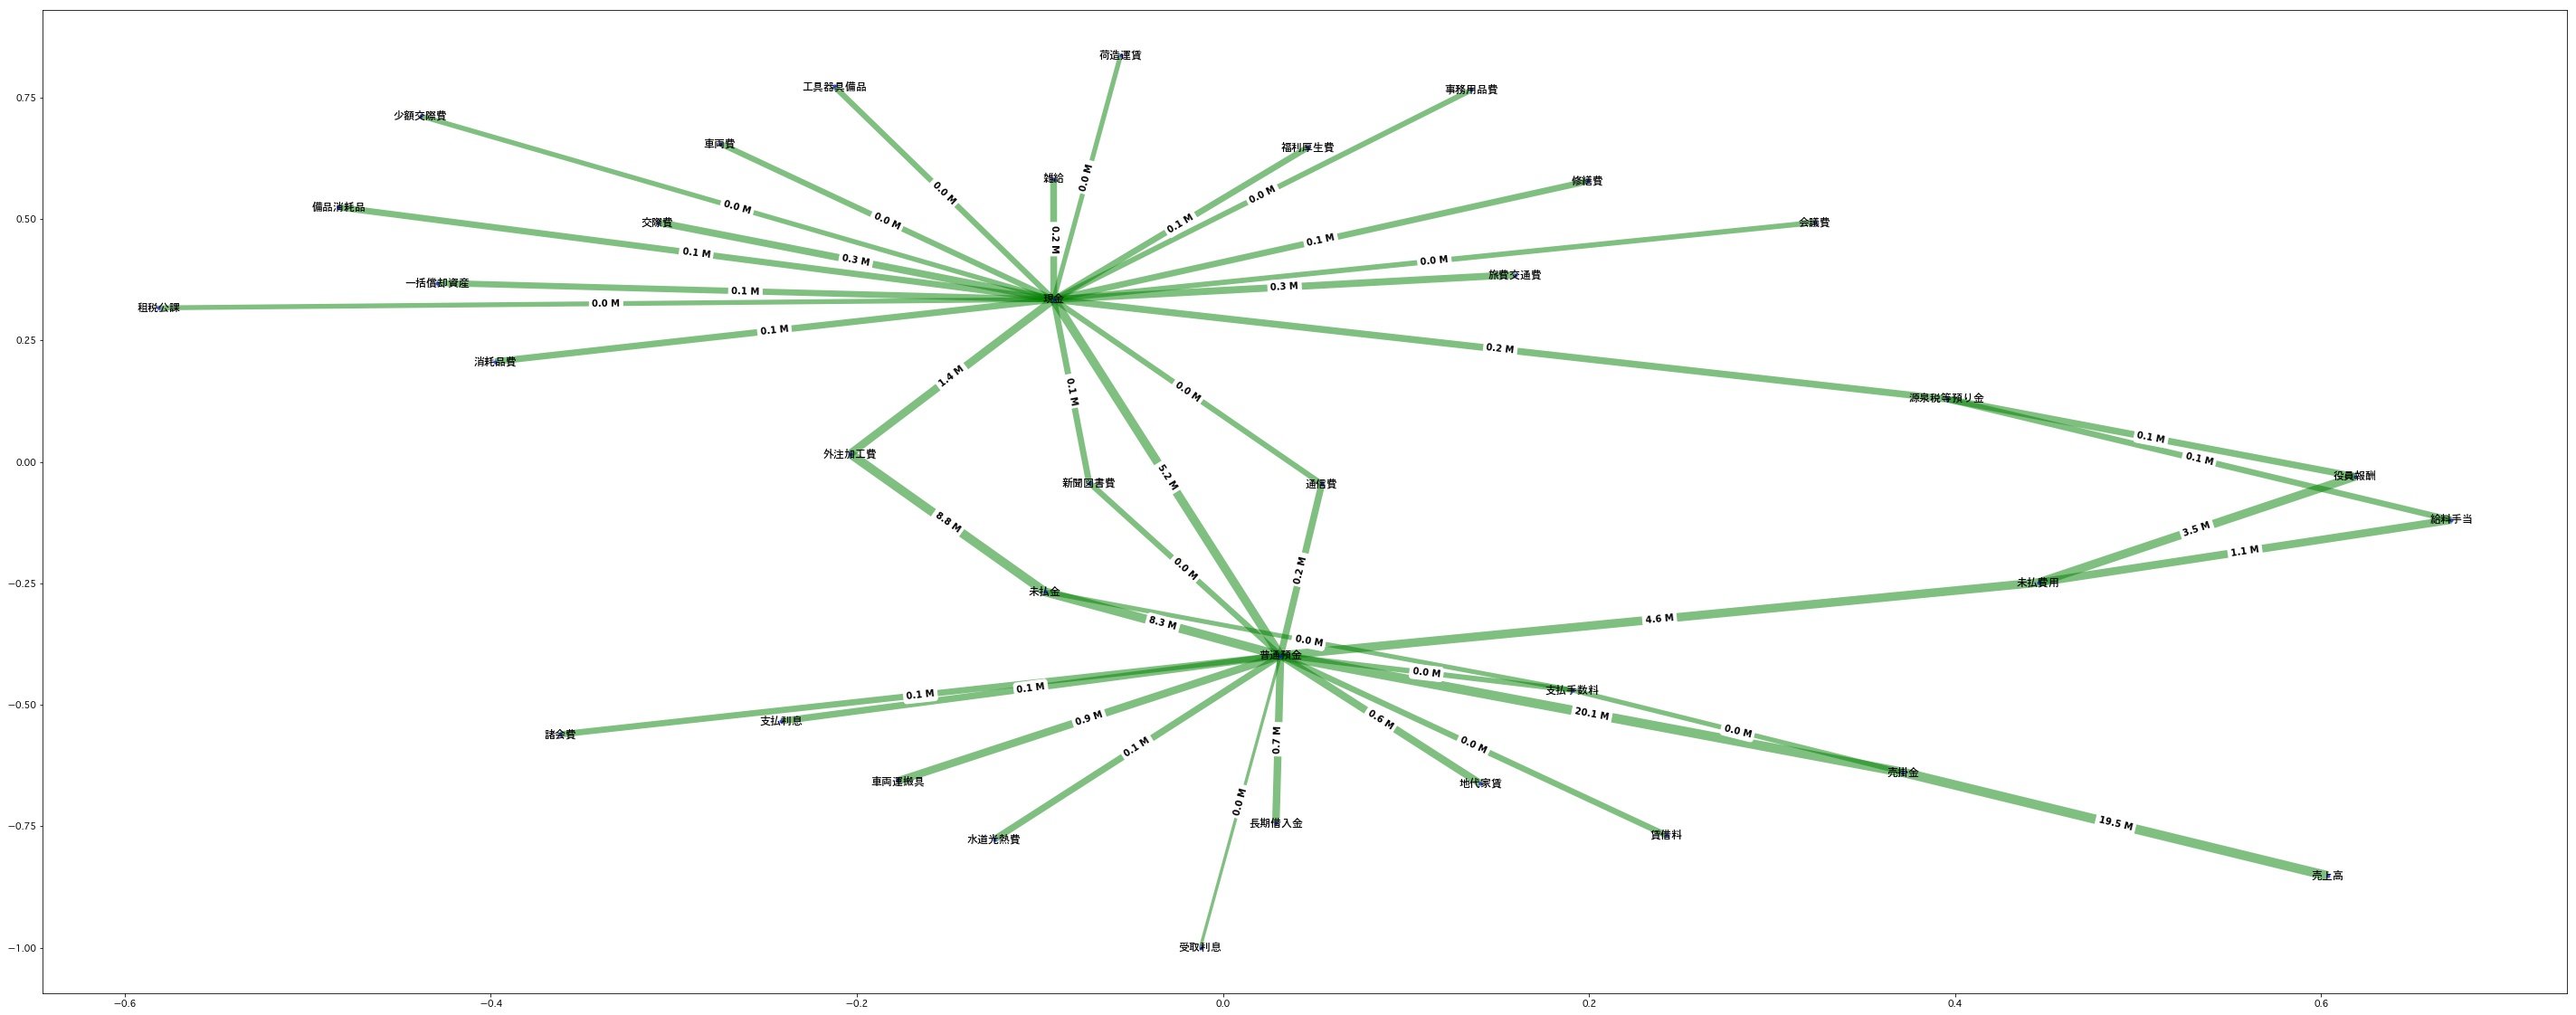

In [5]:
df=transaction_mat_net
threshold=0.000001
G=nx.Graph()
edge_labels={}
for a, b in itertools.combinations(df.columns, 2):
        val1 = df.loc[a, b]
        if abs(val1) > threshold:
            edge_labels[(a,b)]=np.round(val1/1000000,1).astype(str) + " M"
            weigth_tmp=10 * (abs(np.log10(val1)/7) - threshold) / (1 - threshold)
            G.add_edge(a,b, weight=weigth_tmp)

pos = nx.spring_layout(G) # グラフのポジションを力学モデルで決定します。

plt.rcParams['font.family'] = 'Osaka'
plt.figure(figsize=(50,20))

node_size = 10 
nx.draw_networkx_nodes(G, pos, node_color="b",alpha=0.6, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=32, font_family='Osaka', font_weight="bold")
edge_width = [ d["weight"] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color="g", width=edge_width)
nx.draw_networkx_edge_labels(G, pos,fontsize=32,edge_labels=edge_labels,font_weight="bold")
plt.figure(figsize=(50,20))

### 4. 勘定の相関関係

ここから本題です。

仕訳の借方と貸方の関係になる勘定科目同士（上の図でエッジでつながれた科目同士）は同じタイミングで増減するため、相関関係がありそうです。
そこで、勘定科目間の相関行列（相関グラフ）を作成してみます。

In [6]:
def ConvertToJEvector(JE_raw):
    Names=np.concatenate([JE_raw.loc[:,'debit_account_name'].values,JE_raw.loc[:,'credit_account_name'].values])
    TBindex=np.unique(Names)
    JE_vec=pd.DataFrame(np.zeros((TBindex.shape[0],JE_raw.shape[0])),dtype=int)
    JE_vec.index=TBindex
    for itr in range(JE_raw.shape[0]):
        rcd=JE_raw.iloc[itr,:]
        mask_d=rcd["debit_account_name"] == TBindex
        mask_c=rcd["credit_account_name"] == TBindex
        JE_vec.iloc[mask_d,itr]=rcd['debit_amount']
        JE_vec.iloc[mask_c,itr]=rcd['credit_amount']*(-1)
    return JE_vec
        
JE_vec=ConvertToJEvector(JE_raw)

#### 相関行列
ベクトルデータは借方の増加方向をプラス、貸方の増加方向をマイナスにしています。

したがって、例えば、以下の仕訳で現金と預金は負の相関関係になります。

現金 100 / 預金 100

そこで、相関行列は-1倍して借方と貸方の関係になる場合に大きい値をとるようにしています。

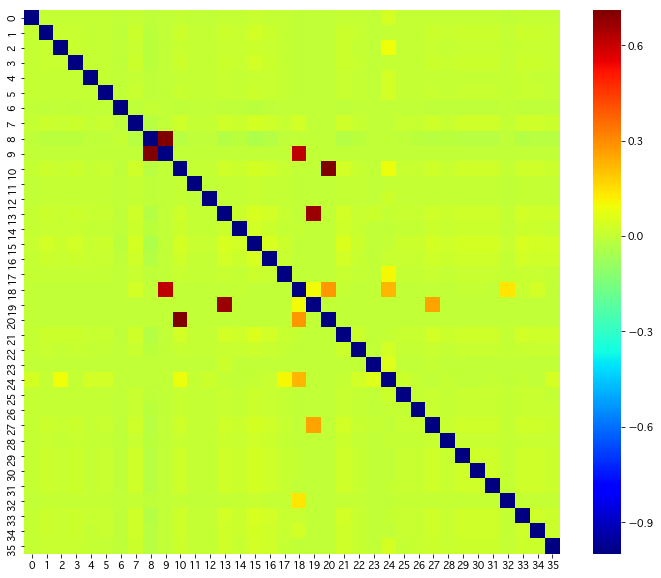

In [57]:

JE_Cor=np.corrcoef(JE_vec)*(-1)
plt.figure(figsize=(12,10))
ax=sns.heatmap(JE_Cor,cmap='jet')

#### 相関グラフ

In [11]:

df=pd.DataFrame((-1)*JE_Cor)
df.index=TBindex
df.columns=TBindex
threshold=0.05
G=nx.Graph()
edge_labels={}
for a, b in itertools.combinations(df.columns, 2):
        val1 = df.loc[a, b]*(-1)
        if abs(val1) > threshold:
            edge_labels[(a,b)]=np.round(val1,1).astype(str)
            #weigth_tmp=10 * (abs(np.log10(val1)/7) - threshold) / (1 - threshold)
            weigth_tmp=10 * (val1 - threshold) / (1 - threshold)
            G.add_edge(a,b, weight=weigth_tmp)        

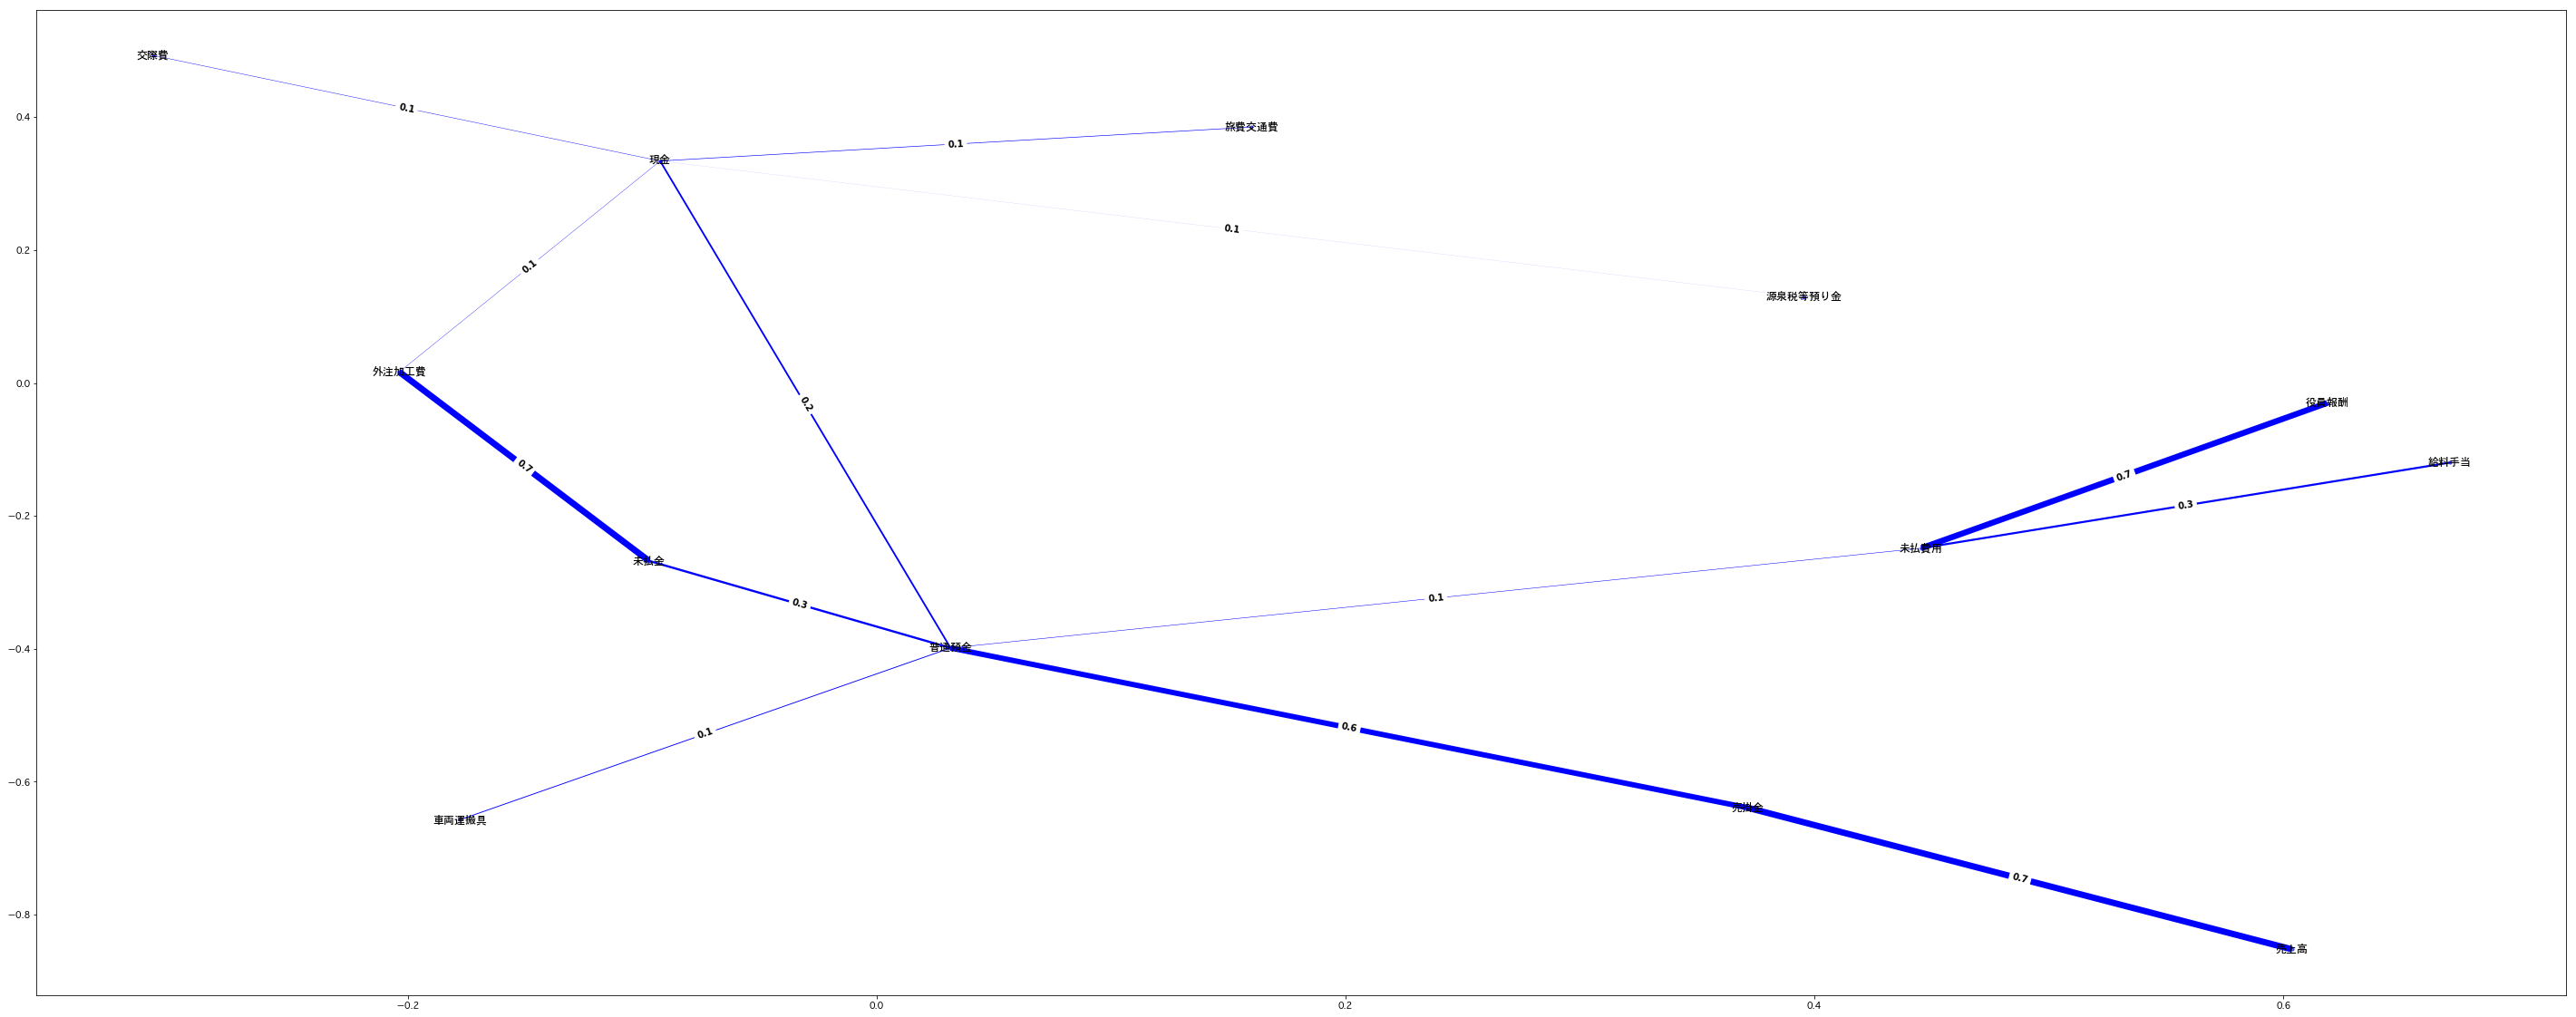

In [12]:

plt.rcParams['font.family'] = 'Osaka'
plt.figure(figsize=(50,20))

node_size = 10 
nx.draw_networkx_nodes(G, pos, node_color="b",alpha=0.6, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=32, font_family='Osaka', font_weight="bold")
edge_width = [ d["weight"] for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=1, edge_color="b", width=edge_width)
nx.draw_networkx_edge_labels(G, pos,fontsize=32,edge_labels=edge_labels,font_weight="bold")
plt.figure(figsize=(50,20))

相関係数が-0.1より小さい科目同士にエッジを描いてます。

例えば、売上と売掛金は相関係数が-0.7になっており、借方貸方の関係になりやすいことが分かります。

逆に仕訳グラフでは預金や現金はいろんな科目と繋がってましたが、相関グラフでは少なくなっています。

預金や現金はいろいろな科目によって変動するため、ある特定の科目の増減だけではあまり説明がつきません。このため、預金や現金周りの相関係数は0に近くなっています。


### 5. 仕訳グラフに基づく重回帰モデル

上のグラフの相関関係を用いれば、ある勘定から他の勘定科目を予想できます。

一方で、現金や預金を予測するにはいろいろな科目を説明変数に用いる必要があります。

そこで重回帰モデルを考えます。説明変数の選択は難しい問題ですが、今回は仕訳グラフで結合しているノードの科目を説明変数にします。

ちなみに、EYの特許では変数選択にLASSOを用いてますが、仕訳が既知であれば真のモデル（仕訳グラフ）を知っているため、それを用いてパラメータの推定を用います。（前期の仕訳データを入手しており、当期の勘定残高の増減を予想する場合などに応用可能です。逆に仕訳データに依拠できない場合はこの方法は有効ではありません。）


In [61]:
mask=transaction_mat_net>0

In [67]:
JE_vec.loc['一括償却資産',:]
JE_vec.loc[mask.loc['一括償却資産',:],:]

,0,1,2,3,4,5,6,7,8,9,...,541,542,543,544,545,546,547,548,549,550
現金,1000000,0,-6480,-500000,0,-4320,0,0,0,-3700,...,0,0,0,0,0,0,0,0,0,0


In [74]:
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()
JE_vec_z=pd.DataFrame(ss.fit_transform(JE_vec.transpose()).transpose(),index=TBindex)

In [99]:
TBindex[0]

'一括償却資産'

In [111]:
from sklearn import linear_model
itr=9
print(TBindex[itr])

est = linear_model.LinearRegression()
target=JE_vec_z.loc[TBindex[itr],:].as_matrix()
exp_data=JE_vec_z.loc[mask.loc[TBindex[itr],:],:]

exp=exp_data.transpose().as_matrix()
est.fit(exp,target)
print(est.coef_)
#print(pd.DataFrame({"Name":exp_data.columns,
#                    "Coefficients":np.abs(est.coef_)}).sort_values(by='Coefficients') )
 
# 切片 (誤差)
from sklearn.metrics import mean_squared_error
pred = est.predict(exp)
print('MSE train data: ', mean_squared_error(target,pred))


売掛金
[-0.70881493  0.02782253 -0.61340663]
MSE train data:  0.12128146562633953


### 6. グラフ上の一つ向こうのノードまで使用した重回帰モデル

In [112]:
from sklearn.metrics import mean_squared_error
pred = est.predict(exp)
print('MSE train data: ', mean_squared_error(target,pred))

MSE train data:  0.12128146562633953


### 失敗したもの

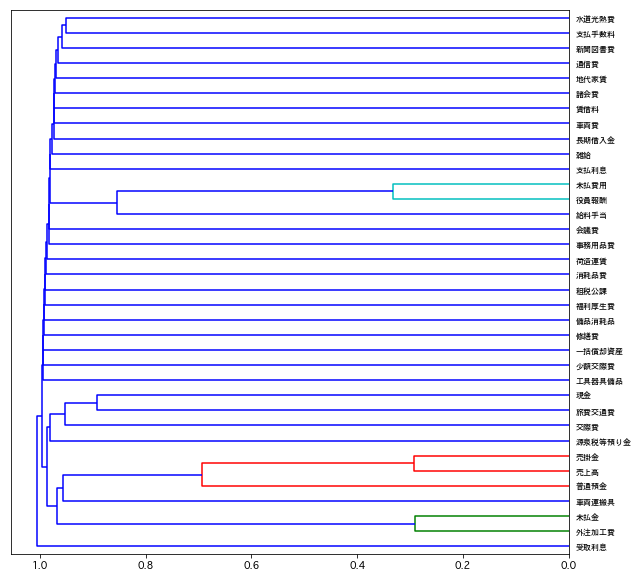

In [59]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import scipy.spatial.distance as distance
#JE_Cor[JE_Cor<0]=0
dArray = distance.squareform(1-JE_Cor,checks=False)

result1 = linkage(dArray, 
                   # JE_vec_red,
                  #metric = 'braycurtis', 
                  #metric = 'canberra', 
                  #metric = 'chebyshev', 
                  #metric = 'cityblock', 
                  #metric = 'correlation', 
                  #metric = 'cosine', 
                  #metric = 'euclidean', 
                  #metric = 'hamming', 
                  #metric = 'jaccard', 
                  #method= 'single')
                  method = 'average')
                  #method = 'ward')
                  #method= 'complete')
                  #method='weighted')
                 
plt.figure(figsize=(10,10))
tree=dendrogram(result1,orientation='left',labels=JE_vec.index)

### 7. References

[1] 
[2] 